In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os

import tensorflow as tf

import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont


# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.15.0
The following GPU devices are available: /device:GPU:0


In [ ]:
def display_image(image_path):
  image = mpimg.imread(image_path)
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def display_np_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):  # Ensures only JPEG images are processed
            img_path = os.path.join(folder, filename)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            images.append(img)
    return images


MODEL 1

Faster R-CNN with Inception ResNet V2

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
model_path = "/content/drive/MyDrive/DL&CNN/AT3/local_resnet_model"

# Check if the model is already saved locally
if os.path.exists(model_path):
    # Load the model from the local path
    detector = tf.saved_model.load(model_path).signatures['default']
else:
    # Load the model from the URL
    detector = hub.load(module_handle).signatures['default']
    # Save the model locally
    tf.saved_model.save(detector, model_path)

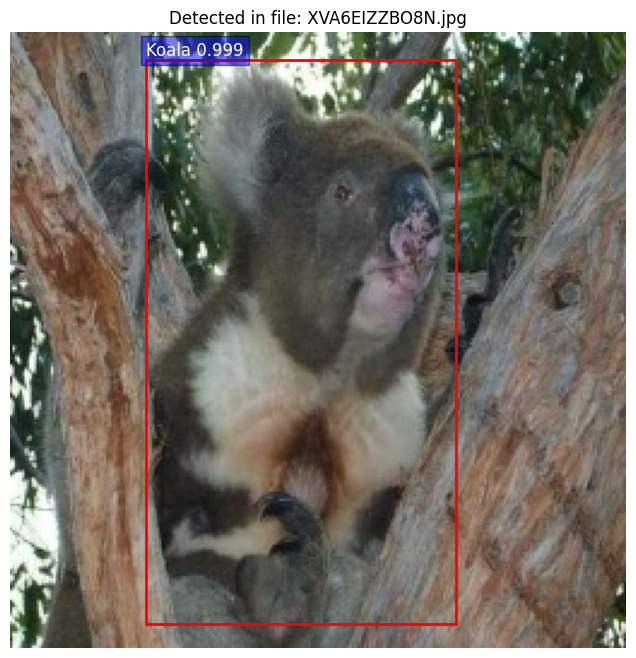

Average Koala Detection Score: 0.26


In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def load_and_process_images(folder_path):
    images = []
    file_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)
            file_paths.append(file_path)
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)
            images.append(img)
    return images, file_paths

def run_detector_on_folder(detector, folder_path):
    images, file_paths = load_and_process_images(folder_path)
    results = []
    koala_scores = []  # List to hold all 'Koala' detection scores
    for img in images:
        converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
        result = detector(converted_img)
        result = {key: value.numpy() for key, value in result.items()}
        results.append(result)
        # Collect 'Koala' scores
        for i in range(len(result['detection_scores'])):
            if result['detection_class_entities'][i] == b'Koala':
                koala_scores.append(result['detection_scores'][i])
    return results, images, file_paths, koala_scores

def display_random_image_with_boxes(images, results, file_paths):
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    result = results[idx]
    file_path = file_paths[idx]

    plt.figure(figsize=(10, 8))
    plt.imshow(img.numpy())
    ax = plt.gca()

    for i in range(len(result['detection_scores'])):
        if result['detection_scores'][i] > 0.5:  # Only display detections above a certain threshold
            if result['detection_class_entities'][i] == b'Koala':  # Filter for 'Koala' only
                ymin, xmin, ymax, xmax = result['detection_boxes'][i]
                rect = plt.Rectangle((xmin*np.shape(img)[1], ymin*np.shape(img)[0]),
                                     (xmax-xmin)*np.shape(img)[1],
                                     (ymax-ymin)*np.shape(img)[0], fill=False,
                                     edgecolor='red', linewidth=2)
                ax.add_patch(rect)
                ax.text(xmin*np.shape(img)[1], ymin*np.shape(img)[0] - 2,
                        '{:s} {:.3f}'.format(result['detection_class_entities'][i].decode("ascii"),
                                             result['detection_scores'][i]),
                        bbox=dict(facecolor='blue', alpha=0.5),
                        fontsize=12, color='white')

    plt.title(f'Detected in file: {os.path.basename(file_path)}')
    plt.axis('off')
    plt.show()

# Example usage
folder_path = "/content/drive/MyDrive/DL&CNN/AT3/images.cv_o2slkbenuaeqji6ncge1k/data/train"
results, images, file_paths, koala_scores = run_detector_on_folder(detector, folder_path)
display_random_image_with_boxes(images, results, file_paths)

# Calculate and print the average detection score for 'Koala'
if koala_scores:
    average_score = sum(koala_scores) / len(koala_scores)
    print(f"Average Koala Detection Score: {average_score:.2f}")
else:
    print("No Koalas were detected in any image.")


MODEL 1 COMPLETE


ONTO MODEL 2

SSD MobileNet V2

In [ ]:
module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
model_path = "/content/drive/MyDrive/DL&CNN/AT3/local_resnetSSD_model"

# Check if the model is already saved locally
if os.path.exists(model_path):
    # Load the model from the local path
    detector = tf.saved_model.load(model_path)
else:
    # Load the model from the URL
    detector = hub.load(module_handle)
    # Create a directory if it does not exist
    os.makedirs(model_path, exist_ok=True)
    # Save the model locally
    tf.saved_model.save(detector, model_path)

# Check available signatures
print("Available signatures:", list(detector.signatures.keys()))

# If 'default' is available, use it, otherwise use an alternative signature
if 'default' in detector.signatures:
    detector = detector.signatures['default']
else:
    # Choose an alternative signature, e.g., 'serving_default'
    detector = detector.signatures['serving_default']

Available signatures: ['serving_default']


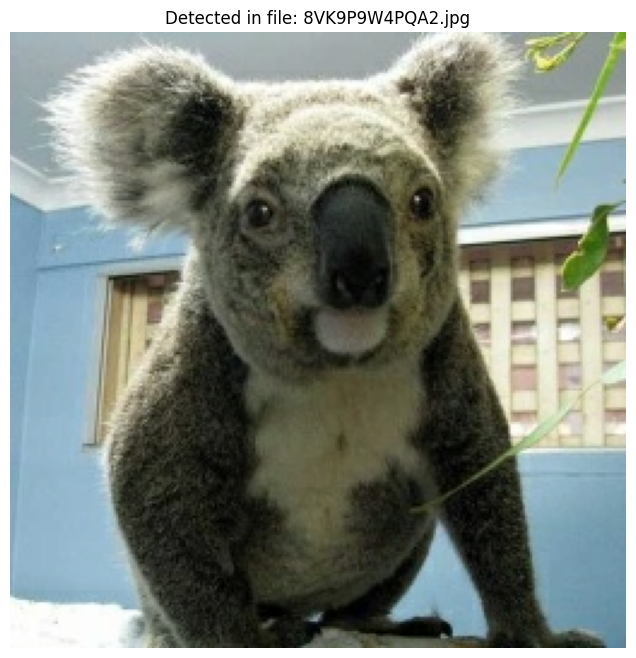

Average Koala Detection Score: 0.63


In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub

def load_and_process_images(folder_path):
    images = []
    file_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)
            file_paths.append(file_path)
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)
            images.append(img)
    return images, file_paths

def run_detector_on_folder(detector, folder_path):
    images, file_paths = load_and_process_images(folder_path)
    results = []
    koala_scores = []  # List to hold all 'Koala' detection scores
    for img in images:
        img = tf.cast(img, tf.uint8)  # Ensure the image tensor is uint8
        converted_img = tf.expand_dims(img, axis=0)  # Add batch dimension without changing dtype
        result = detector(converted_img)
        result = {key: value.numpy() for key, value in result.items()}
        results.append(result)
        # Inspect result keys
        #print("Result keys:", result.keys())  # Add this line to inspect the keys
        # Adjust to use correct keys
        if 'detection_classes' in result:
            detection_classes = result['detection_classes'][0]  # Access the first dimension
            detection_scores = result['detection_scores'][0]
            for i in range(len(detection_scores)):
                # Check if detected class is Koala (adjust class index accordingly)
                if detection_classes[i] == 1:  # Assuming 1 represents Koalas; adjust as necessary
                    if detection_scores[i] > 0.5:  # Only consider high confidence detections
                        koala_scores.append(detection_scores[i])
    return results, images, file_paths, koala_scores


def display_random_image_with_boxes(images, results, file_paths):
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    result = results[idx]
    file_path = file_paths[idx]

    plt.figure(figsize=(10, 8))
    plt.imshow(img.numpy())  # Ensure to convert TensorFlow tensor to NumPy array for plotting
    ax = plt.gca()

    # Directly use the arrays as they are already in numpy format
    detection_scores = result['detection_scores'][0]  # Access first dimension
    detection_classes = result['detection_classes'][0]  # Ensure to access the first dimension
    detection_boxes = result['detection_boxes'][0]  # Ensure to access the first dimension

    for i in range(len(detection_scores)):
        if detection_scores[i] > 0.5:  # Only display detections above a certain threshold
            if detection_classes[i] == 1:  # Assuming 1 represents Koalas; adjust as necessary
                ymin, xmin, ymax, xmax = detection_boxes[i]
                rect = plt.Rectangle((xmin*np.shape(img)[1], ymin*np.shape(img)[0]),
                                     (xmax-xmin)*np.shape(img)[1],
                                     (ymax-ymin)*np.shape(img)[0], fill=False,
                                     edgecolor='red', linewidth=2)
                ax.add_patch(rect)
                ax.text(xmin*np.shape(img)[1], ymin*np.shape(img)[0] - 2,
                        '{:s} {:.3f}'.format(result['detection_class_entities'][i].decode("ascii"),
                                             result['detection_scores'][i]),
                        bbox=dict(facecolor='blue', alpha=0.5),
                        fontsize=12, color='white')

    plt.title(f'Detected in file: {os.path.basename(file_path)}')
    plt.axis('off')
    plt.show()



# Example usage
module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
model_path = "/content/drive/MyDrive/DL&CNN/AT3/local_ssd_mobilenet_model"

# Check if the model is already saved locally
if os.path.exists(model_path):
    # Load the model from the local path
    detector = tf.saved_model.load(model_path)
else:
    # Load the model from the URL
    detector = hub.load(module_handle)
    # Create a directory if it does not exist
    os.makedirs(model_path, exist_ok=True)
    # Save the model locally
    tf.saved_model.save(detector, model_path)

detector = detector.signatures['serving_default']  # Ensure to use the correct signature

folder_path = "/content/gdrive/MyDrive/DL&CNN/AT3/images.cv_o2slkbenuaeqji6ncge1k/data/train"
results, images, file_paths, koala_scores = run_detector_on_folder(detector, folder_path)
display_random_image_with_boxes(images, results, file_paths)

# Calculate and print the average detection score for 'Koala'
if koala_scores:
    average_score = sum(koala_scores) / len(koala_scores)
    print(f"Average Koala Detection Score: {average_score:.2f}")
else:
    print("No Koalas were detected in any image.")


MODEL 3

SSD MobileNet V2 FPNLite 320x320

In [ ]:
module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1"
model_path = "/content/drive/MyDrive/DL&CNN/AT3/local_resnetSSD_model3"

# Check if the model is already saved locally
if os.path.exists(model_path):
    # Load the model from the local path
    detector = tf.saved_model.load(model_path)
else:
    # Load the model from the URL
    detector = hub.load(module_handle)
    # Create a directory if it does not exist
    os.makedirs(model_path, exist_ok=True)
    # Save the model locally
    tf.saved_model.save(detector, model_path)

# Check available signatures
print("Available signatures:", list(detector.signatures.keys()))

# If 'default' is available, use it, otherwise use an alternative signature
if 'default' in detector.signatures:
    detector = detector.signatures['default']
else:
    # Choose an alternative signature, e.g., 'serving_default'
    detector = detector.signatures['serving_default']

Available signatures: ['serving_default']


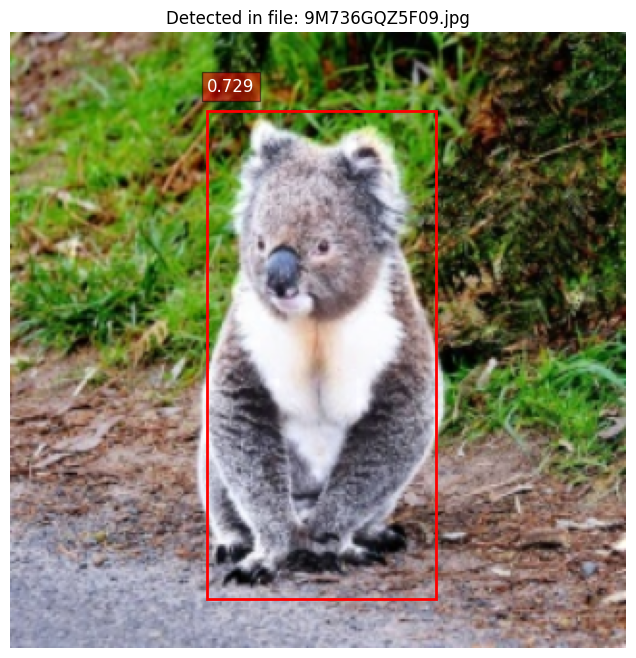

Average Koala Detection Score: 0.67


In [ ]:
import os
import random
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

# Load the model
module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1"
detector = hub.load(module_handle)

# Function to load and process images
def load_and_process_images(folder_path):
    images = []
    file_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)
            file_paths.append(file_path)
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, (320, 320))
            img = tf.cast(img, tf.uint8)
            images.append(img)
    return images, file_paths

# Function to run detector on images
def run_detector_on_folder(detector, folder_path):
    images, file_paths = load_and_process_images(folder_path)
    results = []
    koala_scores = []  # List to store scores for 'Koala' detections
    for img in images:
        converted_img = tf.expand_dims(img, axis=0)
        result = detector(converted_img)
        result = {key: value.numpy() for key, value in result.items()}

        # Assuming the class label for 'Koala' is known and corresponds to a specific index
        koala_class_index = 1  # You need to replace this with the actual class index for 'Koala'
        scores = result['detection_scores'][0]
        classes = result['detection_classes'][0]
        for score, detected_class in zip(scores, classes):
            if detected_class == koala_class_index and score > 0.5:  # Score threshold can be adjusted
                koala_scores.append(score)

        results.append(result)

    return results, images, file_paths, koala_scores

# Function to display a random image with bounding boxes and detection scores
def display_random_image_with_boxes(images, results, file_paths, koala_scores):
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    result = results[idx]
    file_path = file_paths[idx]

    plt.figure(figsize=(10, 8))
    plt.imshow(img.numpy())
    ax = plt.gca()

    detection_scores = result['detection_scores'][0]
    detection_boxes = result['detection_boxes'][0]
    detection_classes = result['detection_classes'][0]

    for score, box in zip(detection_scores, detection_boxes):
        if score > 0.5:
            ymin, xmin, ymax, xmax = box
            (left, right, top, bottom) = (xmin * img.shape[1], xmax * img.shape[1],
                                          ymin * img.shape[0], ymax * img.shape[0])
            rect = plt.Rectangle((left, top), right - left, bottom - top, fill=False,
                                 edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(left, top - 10, f'{score:.3f}', color='white', fontsize=12,
                    bbox=dict(facecolor='red', alpha=0.5))

    plt.title(f'Detected in file: {os.path.basename(file_path)}')
    plt.axis('off')
    plt.show()

    # Display the average score for 'Koala' detections
    if koala_scores:
        average_score = sum(koala_scores) / len(koala_scores)
        print(f"Average Koala Detection Score: {average_score:.2f}")
    else:
        print("No Koalas were detected in any image.")


# Example usage
folder_path = "/content/gdrive/MyDrive/DL&CNN/AT3/images.cv_o2slkbenuaeqji6ncge1k/data/train"
results, images, file_paths, koala_scores = run_detector_on_folder(detector, folder_path)
display_random_image_with_boxes(images, results, file_paths, koala_scores)
